## SMT based solution to VLSI circuit arrangement problem otherwise known as 2 dimensional strip packing problem

##Importing the libraries needed.

In [6]:
!pip install z3-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53.8 MB 303 bytes/s 


In [7]:
!pip install timeout-decorator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5028 sha256=834b9c8abcce344a45a783a7175f71c84d568a55bd02d7ea1cae752ae7f10718
  Stored in directory: /root/.cache/pip/wheels/38/05/4e/161d1463ca145ec1023bd4e5e1f31cbf9239aa8f39a2a2b643
Successfully built timeout-decorator


creating function to be able to plot each instance in a grid.

In [8]:
#ploying the results

import matplotlib.pyplot as plt
import random
import numpy as np
def plot_vlsi(p_x_sol,p_y_sol,x,y, length_sol, image_name):
  fig, ax = plt.subplots(figsize=[5,5])
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

  def plot_rect(ax,x,y,w,h):
      r = random.random()
      b = random.random()
      g = random.random()
      color = (random.random(), random.random(), random.random())
      rect = plt.Rectangle((x,y), w, h,color=color)
      ax.add_patch(rect)    
  for i in range(len(p_x_sol)):
      plot_rect(ax,int(p_x_sol[i]),int(p_y_sol[i]),int(x[i]),int(y[i]))
  plt.axis('square')
  plt.xticks(np.arange(0, w+1, 1))
  plt.yticks(np.arange(0, int(length_sol)+1, 1))
  plt.grid(color = 'black', linestyle = '-', linewidth = 1)
  plt.axis('on') 
  plt.savefig(image_name, bbox_inches='tight',pad_inches = 0)
  return plt.show()



#Creating the model without rotation and with symmetry

In [9]:
from z3 import *
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

def two_d_smt(x_ext, y_ext, plate_width, n,name):
    opt = Optimize()

    areas = [x_ext[i] * y_ext[i] for i in range(n)]
    
    min_h = sum(areas) / plate_width
    max_h = 2*(sum(areas) / plate_width)
    

    p_x = [Int('p_x_%s' % str(i + 1)) for i in range(n)]
    p_y = [Int('p_y_%s' % str(i + 1)) for i in range(n)]
    plate_y = Int("y")

    # domain bound
    for i in range(n):
        opt.add(And(p_x[i] >= 0, p_x[i] <= (plate_width - x_ext[i])))
        opt.add(And(p_y[i] >= 0, p_y[i] <= (plate_y - y_ext[i])))
    opt.add(And(plate_y >= min_h, plate_y <= max_h))

    #cumulative constraint
    for up in range(plate_width):
        opt.add(sum([If(And(p_x[i] <= up, up < p_x[i] + x_ext[i]), y_ext[i], 0) for i in range(n)]) <= plate_y)

    # cumulative constraint
    for uh in range(round(max_h)):
        opt.add(sum([If(And(p_y[i] <= uh, uh < p_y[i] + y_ext[i]), x_ext[i], 0) for i in range(n)]) <= plate_width)

    # domain reduction
    idx = np.argmax([x_ext[i]*y_ext[i] for i in range(n)])
    areas_index = np.argsort([x_ext[i]*y_ext[i] for i in range(n)])
    large_one = areas_index[-1], areas_index[-2]
    idx = np.argmax([x_ext[i]*y_ext[i] for i in range(n)])
    
    opt.add(Or(p_x[large_one[1]] > p_x[large_one[0]], And(p_x[large_one[1]] == p_x[large_one[0]], p_y[large_one[1]] >= p_y[large_one[0]])))
    opt.add(And(p_x[idx] <= ((plate_width - x_ext[idx])/2), p_y[idx] <= ((plate_y - y_ext[idx])/2)))

    zlr = [[Bool(f"lr_{i}_{j}") for j in range(n)] for i in range(n)]
    zud = [[Bool(f"ud_{i}_{j}") for j in range(n)] for i in range(n)]

    #we reduce the domain of the maximum rectangle deﬁned by w, m and h with symmetry 
        

    for (i, j) in combinations(range(n), 2):
        if x_ext[i] + x_ext[j] > plate_width:
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_ext[j] <= p_y[i]))
            opt.add(Or(zud[i][j], zud[j][i]))




    # there are more rectangles in the second half of the x axis then in the first half
    opt.add(sum([If(p_x[i]+ x_ext[i] > plate_width // 2, 1, 0) for i in range(n)]) >= sum([If(p_x[i] + x_ext[i] <= plate_width // 2, 1, 0) for i in range(n)]))


    #for same size rectengles i and j we define that i should be left of j. and/or below j.
    for (i, j) in combinations(range(n), 2):
            if (x_ext[i]==x_ext[j] and y_ext[i]==y_ext[j]):
              opt.add(Or(Not(zlr[i][j]), p_x[i] + x_ext[i] <= p_x[j]))
              opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
              opt.add(Or(zlr[i][j],zud[i][j]))
            else:
              opt.add(Or(Not(zlr[i][j]), p_x[i] + x_ext[i] <= p_x[j]))
              opt.add(Or(Not(zlr[j][i]), p_x[j] + x_ext[j] <= p_x[i]))
              opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
              opt.add(Or(Not(zud[j][i]), p_y[j] + y_ext[j] <= p_y[i]))
              opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))


    opt.minimize(plate_y)

    timeout = 300000
    opt.set("timeout", timeout)
    p_x_sol = []
    p_y_sol = []
    out = opt.check()
    model = opt.model()
    for i in range(n):
        p_x_sol.append(model.evaluate(p_x[i]))
        p_y_sol.append(model.evaluate(p_y[i]))
    e = model.evaluate(plate_y)
    if out == sat:
        solved=1
        print("this instance is satisfiable")
        plot_vlsi(str(p_x_sol),p_y_sol,x,y, e, name)
        for i in range(n):
          print("circuit "+str(i+1)+ " of the dimensions " + str(x[i])+"X"+str(y[i])+" is at ("+str(p_x_sol[i])+","+str(p_y_sol[i])+").\n")
        return e, p_x_sol, p_y_sol, opt.statistics().get_key_value('time'), solved
    
    print('Failed to solve')
    return e, p_x_sol, p_y_sol, 300, 0

In [10]:
def read_data(file):
  with open(file, 'r') as file:
    data=file.read().splitlines()
    w=data[0]
    n=data[1]
    x=[]
    y=[]
    for item in range(int(n)):
      split = data[item + 2].split(' ')
      x.append(int(split[0]))
      y.append(int(split[1]))
  return(int(w), int(n), x, y)
imagenames=['ins1','ins2','ins3','ins4','ins5','ins6','ins7','ins8','ins9','ins10','ins11','ins12','ins13','ins14','ins15','ins16','ins17','ins18','ins19','ins20','ins21','ins22','ins23','ins24','ins25','ins26','ins27','ins28','ins29','ins30','ins31','ins32','ins33','ins34','ins35','ins36','ins37','ins38','ins39','ins40']

file_names=["ins-1.txt","ins-2.txt","ins-3.txt","ins-4.txt","ins-5.txt","ins-6.txt","ins-7.txt","ins-8.txt","ins-9.txt","ins-10.txt","ins-11.txt", "ins-12.txt","ins-13.txt","ins-14.txt","ins-15.txt","ins-16.txt","ins-17.txt","ins-18.txt","ins-19.txt","ins-20.txt","ins-21.txt","ins-22.txt","ins-23.txt","ins-24.txt","ins-25.txt","ins-26.txt","ins-27.txt","ins-28.txt","ins-29.txt","ins-30.txt","ins-31.txt","ins-32.txt","ins-33.txt","ins-34.txt","ins-35.txt","ins-36.txt","ins-37.txt","ins-38.txt","ins-39.txt","ins-40.txt"]

#imagenames=['34','35','36','37','38','39','40']

#file_names=["ins-34.txt","ins-35.txt","ins-36.txt","ins-37.txt","ins-38.txt","ins-39.txt","ins-40.txt"]




solving Instance : ins-1.txt
this instance is satisfiable


ValueError: ignored

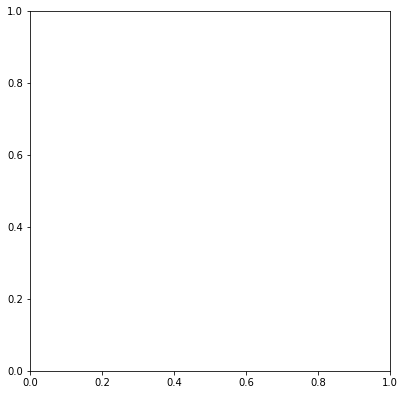

In [12]:
T_sym_NR=[]
heights_1=[]
widths=[]
x_positions=[]
y_positions=[]
solutions=[]
for file in file_names:
  print("solving Instance : "+file)
  w, n, x, y = read_data(file)
  name=imagenames[file_names.index(file)]
  length_sol,p_x_sol, p_y_sol,t, solution=two_d_smt(x,y,w,n,name)
  solutions.append(solution)
  print(length_sol)
  plot_vlsi(p_x_sol,p_y_sol,x,y, length_sol, name)
  #heights.append(int(length_sol))
  #widths.append(int(w))
  #x_positions.append(int(p_x_sol))
  #y_positions.append(int(p_y_sol))
  if solution==1:
    T_sym_NR.append(t)
    heights_1.append(length_sol)
    print("Solves in time :"+str(t)+"seconds")
  else:
    t=0
    heights_1.append(length_sol)
    T_sym_NR.append(t)









In [ ]:
px=[19,16,12,12,6,19,0,3,16,13,9,19,3,0,6,12,9,22,21,22,9,18,15,22]
py=[15,22,0,5,19,18,0,0,11,14,0,0,10,9,0,11,14,21,14,18,0,0]
x=[3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4]
y=[3,4,5,6,7,8,9,10,11,12,14,15,16,17,19,3,4,5,7,8,11,14]
l=26
image_name="instance 19 general model"
plot_vlsi(px,py,x,y, l, image_name)


In [ ]:
fig = plt.figure(figsize = (15, 15))
plt.subplot(221)
# creating the bar plot
plt.bar(imagenames[0:10], T_sym_NR[0:10],
        width = 0.4)
 
plt.xlabel("Instances 1 to 10")
plt.ylabel("Time (seconds) ")
plt.subplot(222)
# creating the bar plot
plt.bar(imagenames[10:20], T_sym_NR[10:20],
        width = 0.4)

plt.xlabel("Instances 11 to 20")
plt.ylabel("Time (seconds) ")
plt.subplot(223)
# creating the bar plot
plt.bar(imagenames[20:30], T_sym_NR[20:30],
        width = 0.4)
 
plt.xlabel("Instances 21 to 30")
plt.ylabel("Time (seconds) ")
plt.subplot(224)
# creating the bar plot
plt.bar(imagenames[30:40], T_sym_NR[30:40],
        width = 0.4)
 
plt.xlabel("Instances")
plt.ylabel("Time (seconds) ")

plt.savefig("resultswithout", bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 15))
# creating the bar plot
plt.bar(imagenames, T_sym_NR, width = 0.4)
 
plt.xlabel("Instances ")
plt.ylabel("Time (seconds) ")
 
plt.savefig("results ", bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
a=0
for i in range(len(T_sym_NR)):
  if T_sym_NR[i]!=0:
    a=a+1
print("The number of instances solved are: "+ str(a))

In [ ]:
print(heights_1)
print(T_sym_NR)

##Without symmetry models

In [ ]:
from z3 import *
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

def two_d_smt_NS_NR(x_ext, y_ext, plate_width, n,name):
    opt = Optimize()
    #upper and lower bounds
    areas = [x_ext[i] * y_ext[i] for i in range(n)]
    min_h = sum(areas) / plate_width
    max_h = 2*(sum(areas) / plate_width)
    #decision variables for x and y coordinates and optimal height
    p_x = [Int('p_x_%s' % str(i + 1)) for i in range(n)]
    p_y = [Int('p_y_%s' % str(i + 1)) for i in range(n)]
    plate_y = Int("y")

    # domain bound____i_e. limits to all the variables
    for i in range(n):
        opt.add(And(p_x[i] >= 0, p_x[i] <= (plate_width - x_ext[i])))
        opt.add(And(p_y[i] >= 0, p_y[i] <= (plate_y - y_ext[i])))
    opt.add(And(plate_y >= min_h, plate_y <= max_h))

    #cumulative constraint
    for up in range(plate_width):
        opt.add(sum([If(And(p_x[i] <= up, up < p_x[i] + x_ext[i]), y_ext[i], 0) for i in range(n)]) <= plate_y)

    # cumulative constraint
    for uh in range(round(max_h)):
        opt.add(sum([If(And(p_y[i] <= uh, uh < p_y[i] + y_ext[i]), x_ext[i], 0) for i in range(n)]) <= plate_width)

    # domain reduction
    idx = np.argmax([x_ext[i]*y_ext[i] for i in range(n)])
    areas_index = np.argsort([x_ext[i]*y_ext[i] for i in range(n)])
    large_one = areas_index[-1], areas_index[-2]
    idx = np.argmax([x_ext[i]*y_ext[i] for i in range(n)])
    opt.add(Or(p_x[large_one[1]] > p_x[large_one[0]], And(p_x[large_one[1]] == p_x[large_one[0]], p_y[large_one[1]] >= p_y[large_one[0]])))
    #opt.add(And(p_x[idx] <= ((plate_width - x_ext[idx])/2), p_y[idx] <= ((plate_y - y_ext[idx])/2)))


    #non overlap Constraint
    zlr = [[Bool(f"lr_{i}_{j}") for j in range(n)] for i in range(n)]
    zud = [[Bool(f"ud_{i}_{j}") for j in range(n)] for i in range(n)]
    for (i, j) in combinations(range(n), 2):
        opt.add(Or(Not(zlr[i][j]), p_x[i] + x_ext[i] <= p_x[j]))
        opt.add(Or(Not(zlr[j][i]), p_x[j] + x_ext[j] <= p_x[i]))
        opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
        opt.add(Or(Not(zud[j][i]), p_y[j] + y_ext[j] <= p_y[i]))
        opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))
    """
    for (i, j) in combinations(range(n), 2):
        if x_ext[i] > (plate_width-x_ext[idx])/2:
            opt.add(Or(Not(zlr[idx][i]), p_x[idx] + x_ext[idx] <= p_x[i]))
            opt.add(Or(Not(zud[i][idx]), p_y[i] + y_ext[i] <= p_y[idx]))
            opt.add(Or(Not(zud[idx][i]), p_y[idx] + y_ext[idx] <= p_y[i]))
            opt.add(Or(zlr[idx][i],zud[i][idx], zud[idx][i]))
        else:
            opt.add(Or(Not(zlr[i][j]), p_x[i] + x_ext[i] <= p_x[j]))
            opt.add(Or(Not(zlr[j][i]), p_x[j] + x_ext[j] <= p_x[i]))
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_ext[j] <= p_y[i]))
            opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))
    
    #Constraint stating that if sum of width of any two circuits is greater than the total plate width allowed, then ith circuit must be either above jth or vice versa. forcing them to be one top of another.
    for (i, j) in combinations(range(n), 2):
        if x_ext[i] + x_ext[j] > plate_width:
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_ext[j] <= p_y[i]))
            opt.add(Or(zud[i][j], zud[j][i]))

        else:
            opt.add(Or(Not(zlr[i][j]), p_x[i] + x_ext[i] <= p_x[j]))
            opt.add(Or(Not(zlr[j][i]), p_x[j] + x_ext[j] <= p_x[i]))
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_ext[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_ext[j] <= p_y[i]))
            opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))
    """

    opt.minimize(plate_y)

    timeout = 300000
    opt.set("timeout", timeout)
    p_x_sol = []
    p_y_sol = []
    out = opt.check()
    model = opt.model()
    for i in range(n):
        p_x_sol.append(model.evaluate(p_x[i]))
        p_y_sol.append(model.evaluate(p_y[i]))
    e = model.evaluate(plate_y)
    if out == sat:
        solved=1
        print("this instance is satisfiable")
        #plot_vlsi(str(p_x_sol),p_y_sol,x,y, e, name)
        for i in range(n):
          print("circuit "+str(i+1)+ " of the dimensions " + str(x[i])+"X"+str(y[i])+" is at ("+str(p_x_sol[i])+","+str(p_y_sol[i])+").\n")
        return e, p_x_sol, p_y_sol, opt.statistics().get_key_value('time'), solved
    
    print('Failed to solve')
    return e, p_x_sol, p_y_sol, 0, 0

In [ ]:

import time
T_NS_NR=[]
heights3=[]
solutions_r=[]
for file in file_names:
  print("solving Instance : "+file)
  w, n, x, y = read_data(file)
  name=imagenames[file_names.index(file)]
  length_sol, p_x_sol, p_y_sol, t, solution=two_d_smt_NS_NR(x,y,w,n,name)
  solutions_r.append(solution)
  #plot_vlsi(p_x_sol,p_y_sol,x,y, length_sol, name)
  if solution==1:
    T_NS_NR.append(t)
    heights3.append(length_sol)
  else:
    T_NS_NR.append(0)
    heights3.append(length_sol)
  print(length_sol)
  print("Solves in time :"+str(t)+"seconds")








In [ ]:
print(heights_1)
print(heights3)
print(T_sym_NR)
print(T_NS_NR)

In [ ]:
pip install xlsxwriter 

In [ ]:
# import xlsxwriter module
import xlsxwriter

workbook = xlsxwriter.Workbook('smt_experiments.xlsx')
worksheet = workbook.add_worksheet()
 
# Use the worksheet object to write
# data via the write() method.
worksheet.write('A1', 'Instance ')
worksheet.write('B1', 'NO_rot_with_Sym')
worksheet.write('C1', 'With_rot_with_Sym')
worksheet.write('D1', 'NO_rot_no_Sym')
worksheet.write('E1', 'With_rot_no_Sym')

#write instance names in excel file
row=1
column=0
imagenames=['ins1','ins2','ins3','ins4','ins5','ins6','ins7','ins8','ins9','ins10','ins11','ins12','ins13','ins14','ins15','ins16','ins17','ins18','ins19','ins20','ins21','ins22','ins23','ins24','ins25','ins26','ins27','ins28','ins29','ins30','ins31','ins32','ins33','ins34','ins35','ins36','ins37','ins38','ins39','ins40']
for item in imagenames:
  worksheet.write(row,column,item)
  row=row+1
#_________write time for each instance in the no rotation with symmetry model____________#
row=1
column=1
for item in T_sym_NR:
  worksheet.write(row,column,item)
  row=row+1

#_________write time for each instance in the no rotation no symmetry model____________#
row=1
column=3
for item in T_NS_NR:
  worksheet.write(row,column,item)
  row=row+1


worksheet.write('F1', 'Height_Sym')
worksheet.write('G1', 'Height_Sym_R')
worksheet.write('H1', 'Height_NSNR')
worksheet.write('I1', 'Height_NS_R')

#_________write time for each instance in the no rotation with symmetry model____________#
row=1
column=5
for item in heights_1:
  worksheet.write(row,column,str(item))
  row=row+1

#_________write time for each instance in the no rotation no symmetry model____________#
row=1
column=7
for item in heights3:
  worksheet.write(row,column,str(item))
  row=row+1

workbook.close()

# Finally, close the Excel file
# via the close() method.


In [ ]:
a=0
for i in range(len(T_NS_NR)):
  if T_NS_NR[i]!=0:
    a=a+1
print("The number of instances solved are: "+ str(a))